# The Backpropogation Algorithm

This notebook provides an overview of the backpropogation learning algorithm applied to a three layer neural network. A starting point for developing intuitions about this algorithm involves revisting logistic regression. Just as it is possible to interpret multivariate linear regression as learning the weights on a linear neuron, it is also possible to interpret logistic regression as learning the weights on a sigmoidal neuron. Learning in the latter case, recall, involves computing the partial derivative of the error with respect to a single incoming weight:

$ \frac{\partial E}{\partial w_i} = \frac{dE}{dy} \frac{dy}{dz} \frac{\partial z}{\partial w_i}$

If we group a large number of these units together to accept the same input vectors, we get a simple two layer network. Then, if we take the activities of these units and provide them as input to yet another group logistic units, a third layer is added to the network. The point here is that a standard neural network can be interpreted as an ensembled extension of logistic regression. The procedure for updating the weights, however, changes because an adjustment to an incoming weight to the hidden layer will have an effect on the activity of a single unit in this layer, which will in turn have an effect on the activities on *all* of the output units. This broad effect needs to be incorporated into our calculation of the derivative of the total error with respect to the weight in question. Notationally, we'll use the letters $i$, $j$, and $k$ to index over units in the first, second (hidden), and third layers in the network. We can calculate the derivative of the overall error with respect to the activity of the $j^{th}$ hidden unit $y_j$ as follows:

$ \frac{\partial E}{\partial y_j} = \sum \limits_{k} w_{jk} \frac{\partial E}{\partial z_k}$

where $\frac{\partial E}{\partial z_k}$ is the partial derivative of the total error with respect to the input $z_k$ to the $k^{th}$ unit in the third layer. With derivatives of the error with respect to the activities in the hidden and output layers, it is possible to compute the gradient of the error with respect to each weight in the network. If the weight is between the hidden layer and the output layer, we use a gradient that should be familiar from logistic regression:

$\frac{\partial E}{\partial w_{jk}} = y_j \cdot \frac{\partial E}{\partial z_k} $

If the weight is between the input layer and the hidden layer, we use the same expression indexed to different layers in the network. However, the partial derivative of the error with respect to the input to a unit in the hidden layer can be expanded out using the sum shown above, as follows:

$\frac{\partial E}{\partial w_{ij}} = y_i \cdot \frac{\partial E}{\partial z_j} = y_i \cdot \frac{\partial y_j}{\partial z_j} \frac{\partial E}{\partial y_j} = y_i \cdot y_j (1- y_j) \cdot \sum \limits_{k} w_{jk} \frac{\partial E}{\partial z_k} $

where the term $y_j(1- y_j)$ is the derivative of the logistic function for a unit in the hidden layer. This procedure generalizes because if we have the derivatives of the overall error with respect to the activities in a particular layer, we can compute the same derivatives for the next layer back using the second equation above (hence the name "backpropogation"). Moreover, we can compute the gradient with respect to any weight in the network provide we have the following two pieces of information: the activity of the "pre" unit (i.e. the unit whose output the weight modifies), and the error derivative of the "post" unit (i.e. the unit whose input the weight modifies). 

The rest of the notebook is concerned with using these mathematical tools to build up to a 3-layer neural network that can be used to classify images of handwritten digits. To start, it is helpful to load the dataset and take a look at a couple of image samples. The dataset is again available through the sklearn machine learning library. Note that it is actually pretty hard to tell what numbers these images correspond to given the low resolution. (This is a toy MNIST-like dataset, and it is readily available through sklearn. It is also quick to test models on, but material below should be readily applicable to building a model for classifying images from MNIST proper).

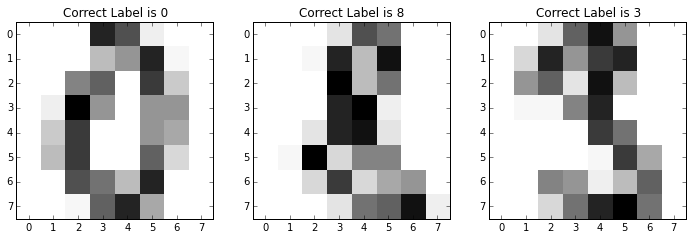

In [100]:
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline

from sklearn import datasets

digits = datasets.load_digits()

# Plot some random selections from the dataset
indices = np.random.randint(0,1000, 3) 
targets = digits.target[indices]

fig = plt.figure(figsize=(12,6))
p1 = fig.add_subplot(1,3,1)
p1.imshow(digits.images[indices[0],:,:], cmap=cm.Greys, interpolation='Nearest')
p1.set_title('Correct Label is %s' %(targets[0]))
p2 = fig.add_subplot(1,3,2)
p2.imshow(digits.images[indices[1],:,:], cmap=cm.Greys, interpolation='Nearest')
p2.set_title('Correct Label is %s' %(targets[1]))
p3 = fig.add_subplot(1,3,3)
p3.imshow(digits.images[indices[2],:,:], cmap=cm.Greys, interpolation='Nearest')
p3.set_title('Correct Label is %s' %(targets[2]))
fig.show()

# Step 1: Multinomial Logistic Regression

As a baseline for comparison, we'll start by classifying the images using multinomial logistic regression. The goal here is to train *n* logistic units to assign probabilities to the likelihood of an input vector belonging to each of $k$ categories. To enforce the condition that the activations of these units always sum to one and form a proper probability distribution, we'll use the softmax output function, which is defined as follows:

$y_k = \frac{e^{z_k}}{\sum \limits_{n} e^{z_n}}$

where $y_k$ is the output of unit $k$, $z_k$ is the total input to unit $k$, and $n$ is a second index over all of the units. The important conceptual shift here is that the activity of a given unit does not depend only on its total input, but also on the total input received by all of the other units. And instead of using the standard squared-error cost function to train the system, we'll use cross-entropy error. This cost function is a slight variation on the cost function used for logistic regression, and can be written as follows:

$J(\theta) = - \sum \limits_{k} t_k \cdot log(y_k) $

The function acts to maximize the log probability of the correct answer by penalizing any deviations between the value of the target unit (i.e. 1) and the predicted value for this unit. It is possible to ignore discrepancys between the predicted output and true output for units that are not the target unit, because *raising* the predicted value of the correct output unit entails *lowering* the predicted values of these other units (due to the fact that the activities in the softmax layer need to sum to 1). The gradient of this cost function with respect to the input to a unit is as follows:

$ \frac{\partial J(\theta)}{\partial z_k} = \sum \limits_k \frac{\partial J(\theta)}{\partial y_k} \frac{\partial y_k}{\partial z_k} =  y_k - t_k $

Deriving this is a bit tricky, because there is a derivative for each softmax unit $j$ with respect to the input to unit $i$ that needs to be taken into consideration. A bunch of stuff in the summation simplifies, yielding the above result. 

To implement multiclass logistic regression, we'll first define a base class that defines methods that are used by all the models described in this notebook. Then we'll inherit from this class define specific models that involve either multiclass logistic regression or a three layer neural network.

In [101]:
class Model(object):
    """
    Base class for grouping functions common to all models described in this notebook. 
    Note that there is an assumption that the target output of models that inherit from 
    this class are binary vectors containing a single non-zero element whose index
    corresponds to the category that the input to the model belongs to.  
    """
    def __init__(self):
        pass
    
    @staticmethod
    def sigmoid(z):
        return 1.0/(1+np.exp(-z))

    @staticmethod
    def softmax(z):
        return np.exp(z) / np.sum(np.exp(z), axis=0)
    
    @staticmethod
    def binarize(targets):
        indices = [tuple(targets),tuple(range(len(targets)))]
        tmatrix = np.zeros((max(targets)+1,len(targets)))
        tmatrix[indices] = 1
        return tmatrix 
    
    def plot_costs(self):
        plt.figure(figsize=(7,5))
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.ylabel('Cost')
        plt.xlabel('Number of Iterations')
        plt.show() 

Now, we can define a logistic regression model that categorizes the images shown above:

In [102]:
class LogisticRegression(Model):
    """
    Performs multiclass logistic regression by performing batch gradient descent.
    
    Parameters:
    -----------
    n_in : int
        The dimensionality of the input vectors being classified.
    n_out : int
        The dimensionality of the output vector that encodes a classification 
        decision. 
    eps : float, optional
        Scaling factor on random weight initialization. By default, the weights
        are chosen from a uniform distribution on the interval [-0.1, 0.1].
    """
    def __init__(self, n_in, n_out, eps=0.1):
        self.weights = np.random.random((n_out, n_in+1))*eps*2-eps
        self.costs = []
    
    def train(self, data, targs, iters, rate=0.5):
        n = float(len(data))
        t = self.binarize(targs)
        
        for _ in range(iters):
            y = self.softmax(np.dot(self.weights, data.T))
            y_grad = y-t
            w_grad = np.dot(y_grad, data) / n 
            self.weights += -rate * w_grad
            self.costs.append(self.get_cost(data, targs))
            
    def predict(self, data):
        output = self.softmax(np.dot(self.weights, data.T))
        return np.argmax(output, axis=0)
    
    def get_cost(self, data, targs):
        t = self.binarize(targs)
        n = float(len(data))
        t = self.binarize(targs)
        yj = self.softmax(np.dot(self.weights, data.T))
        return np.sum(-np.log(yj) * t) / n

    def test_accuracy(self, data, targs): 
        correct = sum(np.equal(self.predict(data), targs))
        return correct / float(len(targs))

Next, we'll do some pre-processing to the data and then test the classifier:

Initial Test Accuracy:  0.1
Final Test Accuracy:  0.886111111111


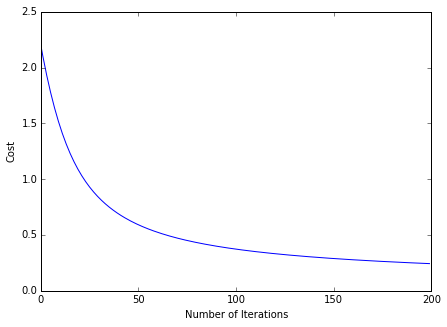

In [103]:
# Number of data points and input dimensionality.
n = len(digits.images)
d = 64

# Set train-test ratio
ratio = 0.8

# Normalize features and add bias terms to dataset
images = digits.images.reshape(n, d)
images = images / np.max(images)
images = np.append(np.ones((n,1)), images, axis=1)    

# Split into train and test sets
train_data = images[range(int(ratio*n)),:]
train_targs = digits.target[range(int(ratio*n))]
test_data = images[range(int(ratio*n),n),:]
test_targs = digits.target[range(int(ratio*n), n)]

# Train the model and display results
classifier = LogisticRegression(d, 10) 

print 'Initial Test Accuracy: ', classifier.test_accuracy(test_data, test_targs)

classifier.train(train_data, train_targs, iters=200)

print 'Final Test Accuracy: ', classifier.test_accuracy(test_data, test_targs)

classifier.plot_costs()

Finally, we'll plot some predictions along with the weights into a few of the units in the classifier.

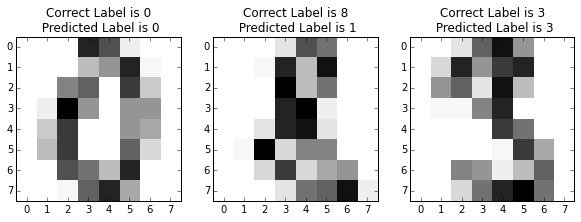

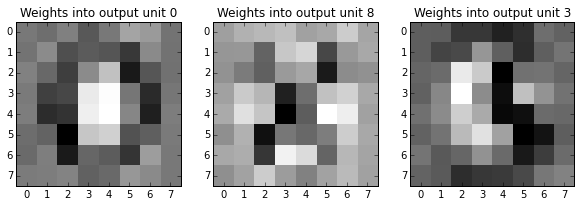

In [104]:
# Plot predictions for previously shown display items
predictions = classifier.predict(train_data)[indices]
fig = plt.figure(figsize=(10,8))
p1 = fig.add_subplot(1,3,1)
p1.imshow(digits.images[indices[0],:,:], cmap=cm.Greys, interpolation='Nearest')
p1.set_title('Correct Label is %s \n Predicted Label is %s' %(targets[0], predictions[0]))
p2 = fig.add_subplot(1,3,2)
p2.imshow(digits.images[indices[1],:,:], cmap=cm.Greys, interpolation='Nearest')
p2.set_title('Correct Label is %s \n Predicted Label is %s' %(targets[1], predictions[1]))
p3 = fig.add_subplot(1,3,3)
p3.imshow(digits.images[indices[2],:,:], cmap=cm.Greys, interpolation='Nearest')
p3.set_title('Correct Label is %s \n Predicted Label is %s' %(targets[2], predictions[2]))
fig.show()

# Plot weights into a random selection of the output units.
fig = plt.figure(figsize=(10,8))
p1 = fig.add_subplot(1,3,1)
p1.imshow(classifier.weights[targets[0],1:].reshape(8,8), cmap=cm.Greys, interpolation='Nearest')
p1.set_title('Weights into output unit %s' %(targets[0]))
p2 = fig.add_subplot(1,3,2)
p2.imshow(classifier.weights[targets[1],1:].reshape(8,8), cmap=cm.Greys, interpolation='Nearest')
p2.set_title('Weights into output unit %s' %(targets[1]))
p3 = fig.add_subplot(1,3,3)
p3.imshow(classifier.weights[targets[2],1:].reshape(8,8), cmap=cm.Greys, interpolation='Nearest')
p3.set_title('Weights into output unit %s' %(targets[2]))
fig.show()

These results indicate that multinomial logistic regression actually does quite well at categorizing the images. Chance performance is ~10% accuracy, and after training, our system classifies 85-90% of the test images correctly. The weights into the output softmax units are also quite interesting. Dark regions indicate portions of the input that the classifier thinks are highly predictive of membership in the class in question. White regions indicate portions of the input that, when active, are typically incompatible with membership in the class in question. For example, the classifier isn't likely to identify an image as a 3 if there is considerable activation in the center-left portion of the image. 

# Step 2: Adding a Hidden Layer to Create an Artificial Neural Network

Next, to try and improve the performance of the classifier, we'll add a hidden layer of units that computes its activities directly from the input images. Then, we'll provide these activities as the inputs to a group of softmax units of the sort just described. The resulting system is a three-layer neural network.

Initial Test Accuracy:  0.0972222222222
Final Test Accuracy:  0.897222222222


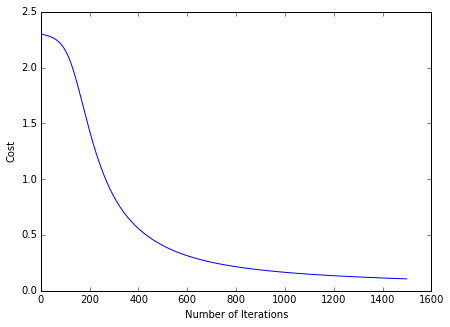

In [105]:
class NeuralNetwork(Model):
    """
    A three layer neural network for performing classification. 
    
    Parameters:
    -----------
    n_in : int
        The dimensionality of the input vectors being classified.
    n_hid : int 
        The dimensionality of the hidden layer of the network.
    n_out : int
        The dimensionality of the output vector that encodes a classification 
        decision. (i.e. a probability distribution over labels)
    eps : float, optional
        Scaling factor on random weight initialization. By default, the weights
        are chosen from a uniform distribution on the interval [-0.1, 0.1].
    """
    def __init__(self, n_in, n_hid, n_out, eps=0.1):
        self.w1 = np.random.random((n_hid, n_in+1))*eps*2-eps
        self.w2 = np.random.random((n_out, n_hid+1))*eps*2-eps
        self.costs = []

    def train(self, data, targs, iters, rate=0.3):
        n = float(len(data))
        t = self.binarize(targs)
        
        for _ in range(iters):
            # Compute activations
            yj = self.sigmoid(np.dot(self.w1, data.T))
            yj = np.append(np.ones((1, n)), yj, axis=0)
            yk = self.softmax(np.dot(self.w2, yj))
            
            # Compute gradients               
            yk_grad = yk-t
            yj_grad = np.dot(self.w2.T, yk_grad) * (yj*(1-yj))
            yj_grad = yj_grad[1:,:] # Ignore bias unit        
            w2_grad = np.dot(yk_grad, yj.T) / n
            w1_grad = np.dot(yj_grad, data) / n
    
            # Update weights
            self.w1 += -rate * w1_grad
            self.w2 += -rate * w2_grad
                           
            # Log the cost of the current weights
            self.costs.append(self.get_cost(data, targs))
        
    def get_cost(self, data, targs):
        n = float(len(data))
        t = self.binarize(targs)
        yj = self.sigmoid(np.dot(self.w1, data.T))
        yj = np.append(np.ones((1, n)), yj, axis=0)
        yk = self.softmax(np.dot(self.w2, yj))
        return np.sum(-np.log(yk) * t) / n
        
    def predict(self, data):
        yj = self.sigmoid(np.dot(self.w1, data.T))
        yj = np.append(np.ones((1,len(data))), yj, axis=0)
        t = self.softmax(np.dot(self.w2, yj))
        return np.argmax(t, axis=0)

    def test_accuracy(self, data, targs): 
        correct = sum(np.equal(self.predict(data), targs))
        return correct / float(len(targs))
    
# Train the model and display results
classifier = NeuralNetwork(64, 20, 10) 
print 'Initial Test Accuracy: ', classifier.test_accuracy(test_data, test_targs)
classifier.train(train_data, train_targs, iters=1500)

print 'Final Test Accuracy: ', classifier.test_accuracy(test_data, test_targs)
classifier.plot_costs()

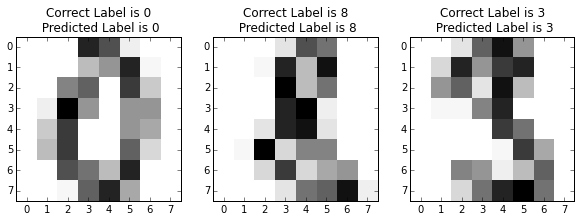

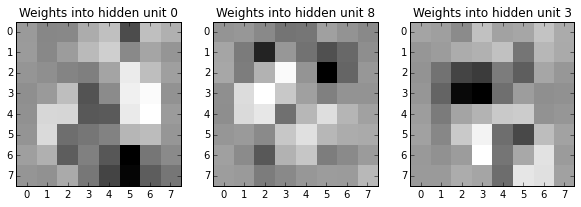

In [106]:
# Plot predictions for previously shown display items
predictions = classifier.predict(train_data)[indices]
fig = plt.figure(figsize=(10,8))
p1 = fig.add_subplot(1,3,1)
p1.imshow(digits.images[indices[0],:,:], cmap=cm.Greys, interpolation='Nearest')
p1.set_title('Correct Label is %s \n Predicted Label is %s' %(targets[0], predictions[0]))
p2 = fig.add_subplot(1,3,2)
p2.imshow(digits.images[indices[1],:,:], cmap=cm.Greys, interpolation='Nearest')
p2.set_title('Correct Label is %s \n Predicted Label is %s' %(targets[1], predictions[1]))
p3 = fig.add_subplot(1,3,3)
p3.imshow(digits.images[indices[2],:,:], cmap=cm.Greys, interpolation='Nearest')
p3.set_title('Correct Label is %s \n Predicted Label is %s' %(targets[2], predictions[2]))
fig.show()

# Plot weights into a random selection of the output units.
fig = plt.figure(figsize=(10,8))
p1 = fig.add_subplot(1,3,1)
p1.imshow(classifier.w1[targets[0],1:].reshape(8,8), cmap=cm.Greys, interpolation='Nearest')
p1.set_title('Weights into hidden unit %s' %(targets[0]))
p2 = fig.add_subplot(1,3,2)
p2.imshow(classifier.w1[targets[1],1:].reshape(8,8), cmap=cm.Greys, interpolation='Nearest')
p2.set_title('Weights into hidden unit %s' %(targets[1]))
p3 = fig.add_subplot(1,3,3)
p3.imshow(classifier.w1[targets[2],1:].reshape(8,8), cmap=cm.Greys, interpolation='Nearest')
p3.set_title('Weights into hidden unit %s' %(targets[2]))
fig.show()

Overall, there does not seem to be much of an improvement on this dataset when switching from multiclass logistic regression to a full-blown neural network. With slight changes to the learning rate and number of learning iterations, it appears that both methods peak at about 93% accuracy on the test set. It may be the case that changes to other parameters (such as the number of hidden units) would give a slight edge to the neural network, but there doesn't seems to be much of a difference overall (though it appears the neural net often fails to make errors where multiclass logistic regression does). Finally, one interesting thing about the neural network is that we can see which features the network has learned to use by plotting the weights entering into a subset of the units in the hidden layer. These features seem to involve pixel activity at fairly specific locations in the input.